In [21]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [22]:
os.getcwd()

'/workspace'

In [23]:
# from zipfile import ZipFile
# zf = ZipFile('/workspace/test_vid.zip', 'r')
# zf.extractall('/workspace/')
# zf.close()

In [24]:
loc_img="/workspace/test_img"
# len(os.listdir(loc_img))
# os.listdir('/workspace/test_vid/depth_frames/')

In [25]:
class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(loc_img))

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.root_dir,os.listdir(loc_img)[idx])
        image = (Image.open(img_name))

        sample1={'image': image}

        if self.transform:  sample1 = self.transform({'image': image})
        return sample1

0 (3840, 2160)
1 (3840, 2160)
2 (2160, 2136)
3 (3840, 2160)
4 (3840, 2160)
5 (3840, 2160)
6 (3840, 2160)
7 (3840, 2160)
8 (3840, 2160)
9 (3840, 2160)
10 (3840, 2160)
11 (3840, 2160)
12 (3840, 2160)
13 (3840, 2160)
14 (3840, 2160)
15 (3840, 2160)
16 (3840, 2160)
17 (4032, 3024)
18 (4032, 3024)
19 (4032, 3024)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


20 (4032, 3024)
21 (4032, 3024)
22 (4032, 3024)
23 (4032, 3024)
24 (4032, 3024)
25 (4032, 3024)
26 (4032, 3024)
27 (2878, 1698)


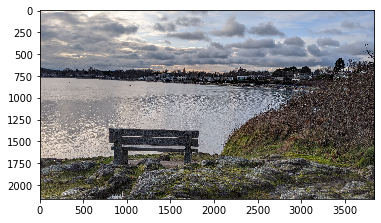

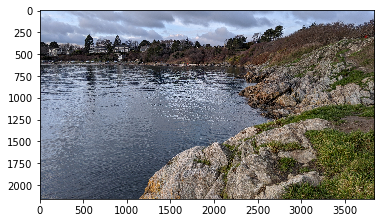

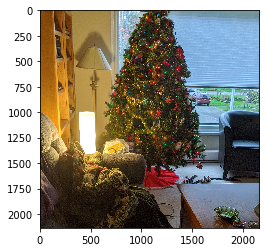

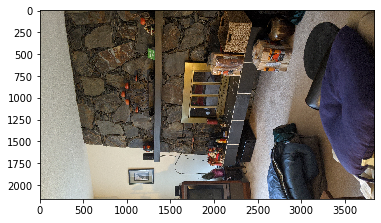

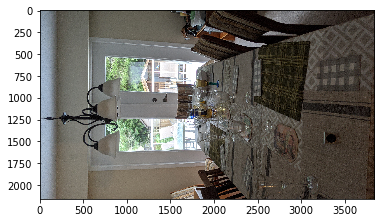

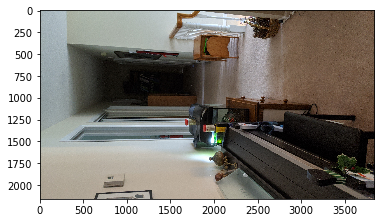

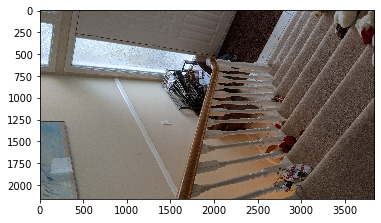

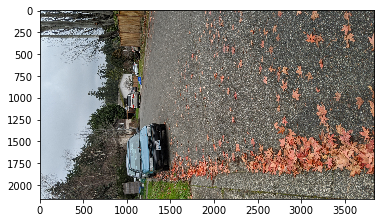

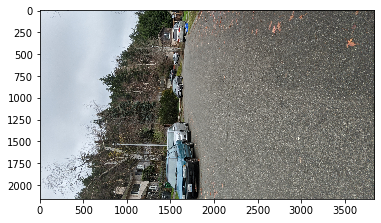

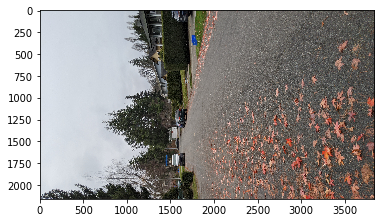

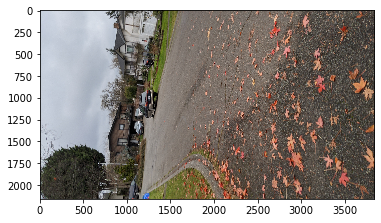

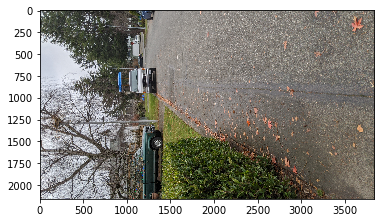

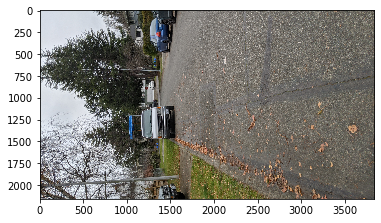

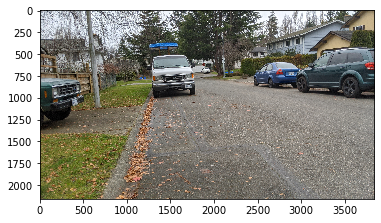

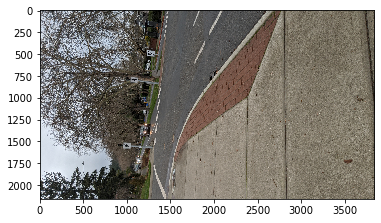

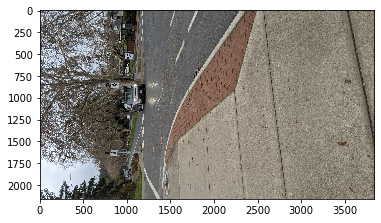

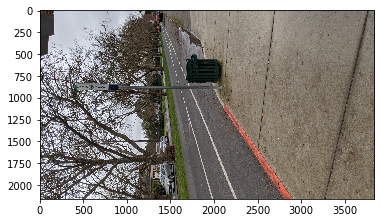

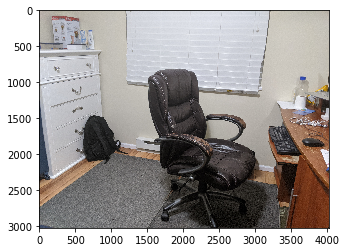

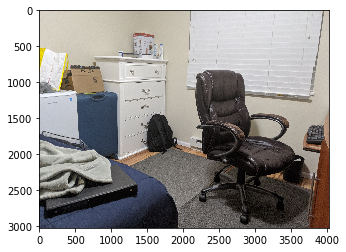

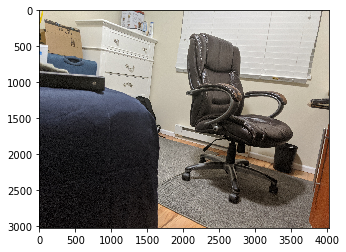

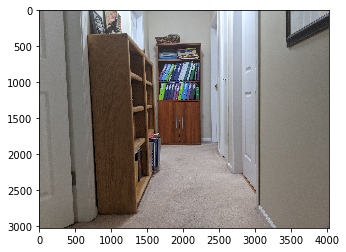

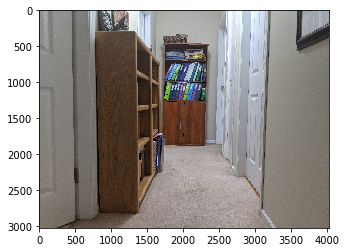

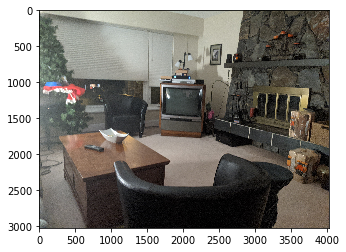

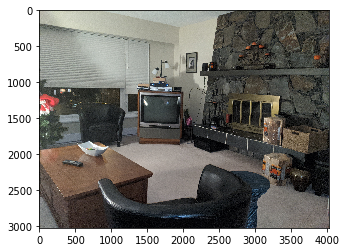

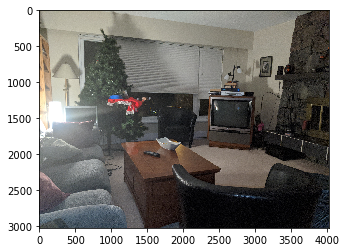

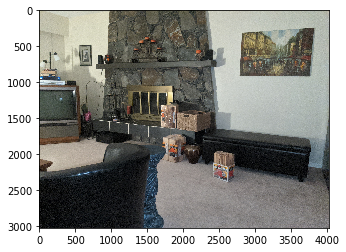

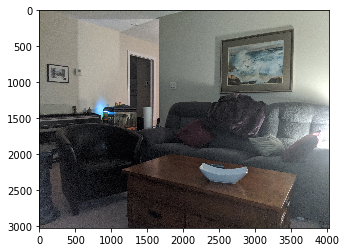

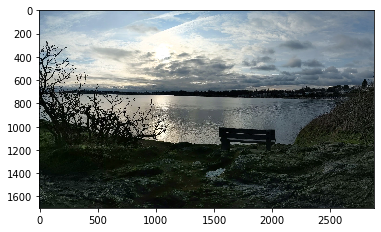

<Figure size 432x288 with 0 Axes>

In [26]:
depth_dataset = DepthDataset(root_dir=loc_img)
fig = plt.figure()
len(depth_dataset)
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]

    print(i, sample['image'].size)


    plt.imshow(sample['image'])
    plt.figure()


#     if i == 2:
#         plt.show()
#         break

In [27]:
def _is_pil_image(img):
    return isinstance(img, Image.Image)

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})
class ToTensor(object):
    def __init__(self,is_test=False):
        self.is_test = is_test

    def __call__(self, sample):
        image= sample['image']
        
        image = image.resize((640, 480))
        image = self.to_tensor(image)

        return {'image': image}

    def to_tensor(self, pic):
        pic = np.array(pic)
        if not (_is_numpy_image(pic) or _is_pil_image(pic)):
                raise TypeError(  'pic should be PIL Image or ndarray. Got {}'.format(type(pic)))
                
#         if not(_is_pil_image(pic)): 
#             raise TypeError(
#                 'pic should be PIL Image . Got {}'.format(type(pic)))        
               
        if isinstance(pic, np.ndarray):
            if pic.ndim==2:
                pic=pic[..., np.newaxis]
                
            img = torch.from_numpy(pic.transpose((2, 0, 1)))

            return img.float().div(255)


In [28]:
depth_dataset = DepthDataset(root_dir=loc_img,
                transform=transforms.Compose([ToTensor()]))
depth_dataset

In [29]:
batch_size=1
train_loader=torch.utils.data.DataLoader(depth_dataset, batch_size)
train_loader

In [30]:
dataiter = iter(train_loader)
images = dataiter.next()



In [31]:
from model_dense import Model

In [32]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
import cv2
model = Model().cuda()
model = nn.DataParallel(model)
model.load_state_dict(torch.load('/workspace/3.pth'))
model.eval()


DataParallel(
  (module): Model(
    (encoder): Encoder(
      (original_model): DenseNet(
        (features): Sequential(
          (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu0): ReLU(inplace)
          (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (denseblock1): _DenseBlock(
            (denselayer1): _DenseLayer(
              (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu1): ReLU(inplace)
              (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (relu2): ReLU(inplace)
              (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [33]:
for i,sample_batched1  in enumerate (train_loader):
    image1 = torch.autograd.Variable(sample_batched1['image'].cuda())
    
    outtt=model(image1 )
    x=outtt.detach().cpu().numpy()
    x.shape
    x=x.reshape(120,160)
#     plt.figure()
#     plt.imshow(x)
#     plt.figure()
#     plt.imshow(sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0))

    img=x
    scale_percent = 120 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    plt.imsave('/workspace/test_img/geeks%d.jpg' %i, resized, cmap='inferno')
#     if i==2:
#         break
    


RuntimeError: CUDA out of memory. Tried to allocate 6.38 MiB (GPU 0; 7.93 GiB total capacity; 2.87 GiB already allocated; 10.31 MiB free; 114.09 MiB cached)